In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab
from pylab import rcParams
import seaborn as sns
from scipy import stats

%matplotlib inline

# Loading DataFrames

In [4]:
AccList = pd.read_csv("../Data/AccListFrom1001Arabidopsis.csv")
AccList.rename(columns={'tg_ecotypeid': 'Ecotype'}, inplace=True)

SraRunTable = pd.read_csv("../Data/SraRunTable.txt", sep = "\t")
SraRunTable.rename(columns={'ecotype_s': 'Ecotype'}, inplace=True)

AccListSraRunTable = pd.merge(AccList, SraRunTable)
AccListSraRunTable.rename(columns = {'Run_s' : 'ACCESSION', 'latitude' : 'LATITUDE', 'longitude' : 'LONGITUDE'}, inplace=True)

# All data from VCF, parsed and saved as DataFrame, merged with WorldClim BioClim data
AllGeneData = pd.read_csv('../Data/AllGenesDataFrame_bioClim.tab', sep = "\t")
mask1 = AllGeneData.LEN_ALTVAR1 == '-'
mask2 = AllGeneData.LEN_ALTVAR2 == '-'
mask3 = AllGeneData.ALTVAR1_MOTIF == '-'
mask4 = AllGeneData.ALTVAR2_MOTIF == '-'
AllGeneData.loc[mask1, 'LEN_ALTVAR1'] = AllGeneData.loc[mask1, 'LEN_REF']
AllGeneData.loc[mask2, 'LEN_ALTVAR2'] = AllGeneData.loc[mask2, 'LEN_REF']
AllGeneData.loc[mask3, 'ALTVAR1_MOTIF'] = AllGeneData.loc[mask3, 'REF_MOTIF']
AllGeneData.loc[mask4, 'ALTVAR2_MOTIF'] = AllGeneData.loc[mask4, 'REF_MOTIF']
AllGeneData.LEN_ALTVAR1 = AllGeneData.LEN_ALTVAR1.astype(int)
AllGeneData.LEN_ALTVAR2 = AllGeneData.LEN_ALTVAR2.astype(int)

# Trinucleotides
mask = (AllGeneData['UNITLEN'].str.len() == 3)
TriFullFrame = AllGeneData.loc[mask]

# Filtering out bad repeats

In [99]:
codon_list = ['ATT', 'ATC', 'ATA', 'CTT', 'CTC', 'CTA', 'CTG', 'TTA', 'TTG', 'GTT', 'GTC', 'GTA', 'GTG', 'TTT', 'TTC',
    'ATG', 'TGT', 'TGC', 'GCT', 'GCC', 'GCA', 'GCG', 'GGT', 'GGC', 'GGA', 'GGG', 'CCT', 'CCC', 'CCA', 'CCG',
    'ACT', 'ACC', 'ACA', 'ACG', 'TCT', 'TCC', 'TCA', 'TCG', 'AGT', 'AGC', 'TAT', 'TAC', 'TGG', 'CAA', 'CAG',
    'AAT', 'AAC', 'CAT', 'CAC', 'GAA', 'GAG', 'GAT', 'GAC', 'AAA', 'AAG', 'CGT', 'CGC', 'CGA', 'CGG', 'AGA', 'AGG']

four_units_list = []
for codon in codon_list:
    four_units_list.append(codon * 4)
    
string = ''
for motif in four_units_list:
    string = string + motif + '|'
    
TriFullFrameFiltered = TriFullFrame[TriFullFrame['REF_MOTIF'].str.contains(string[:-1], case=False)]

# Getting standard deviations of repeat lengths (in bp) per accession

In [100]:
# Getting absolute lengths of all motifs

ref_abs_length = [len(col) for col in TriFullFrameFiltered['REF_MOTIF']]
TriFullFrameFiltered.loc[:, ('REF_ABS_LENGTH')] = ref_abs_length
TriFullFrameFiltered.loc[:, ('DIFF1_ABS_LENGTH')] = TriFullFrameFiltered['REF_ABS_LENGTH'] + TriFullFrameFiltered['DIFF1']
TriFullFrameFiltered.loc[:, ('DIFF2_ABS_LENGTH')] = TriFullFrameFiltered['REF_ABS_LENGTH'] + TriFullFrameFiltered['DIFF2']

In [101]:
# Looking at genes with only one repeat locus, goes from ~2200 to ~1800 genes
gene_std = TriFullFrameFiltered.groupby(['GENE']).std()
genes = gene_std.loc[gene_std['REF_ABS_LENGTH'] == 0]

# Calculating mean lengths per gene across all individuals
mean = TriFullFrameFiltered[TriFullFrameFiltered['GENE'].isin(genes.index)].groupby('GENE').mean()

In [102]:
# Calculating the mean of both alleles
mean['POP_LENGTH_MEAN'] = (mean['DIFF1_ABS_LENGTH'] + mean['DIFF2_ABS_LENGTH']) / 2

In [103]:
mean_per_gene_to_be_merged = mean[['POP_LENGTH_MEAN']].reset_index()

In [105]:
df = pd.merge(TriFullFrameFiltered, mean_per_gene_to_be_merged)

In [108]:
# Getting means per individual
df.loc[:, ('MEAN_ABS_LENGTH')] = (df['DIFF1_ABS_LENGTH'] + 
                                           df['DIFF2_ABS_LENGTH']) / 2

In [121]:
# Reducing DataFrame for speed
df = df[['GENE', 'ACCESSION', 'MEAN_ABS_LENGTH', 'POP_LENGTH_MEAN']]

# Do this for every accession

# Place results in this dictionary
d = {}
for accession in set(df.ACCESSION):
    g = df[df['ACCESSION']==accession]
    # Here we calculate the mean of the difference between the repeat length in the individual and the mean
    # for that gene in the entire population. We use absolute values as we are only interested in the difference
    # no matter if its an increase or a decrease in length.
    diff_from_pop_mean = np.mean(abs(g.MEAN_ABS_LENGTH - g.POP_LENGTH_MEAN))
    d.update({accession : diff_from_pop_mean})

In [124]:
frame = pd.DataFrame.from_dict(d, orient='index').reset_index().rename(columns = {'index' : 'ACCESSION', 0 : 'DIFF_FROM_POP_MEAN'})

How does the distribution look like?

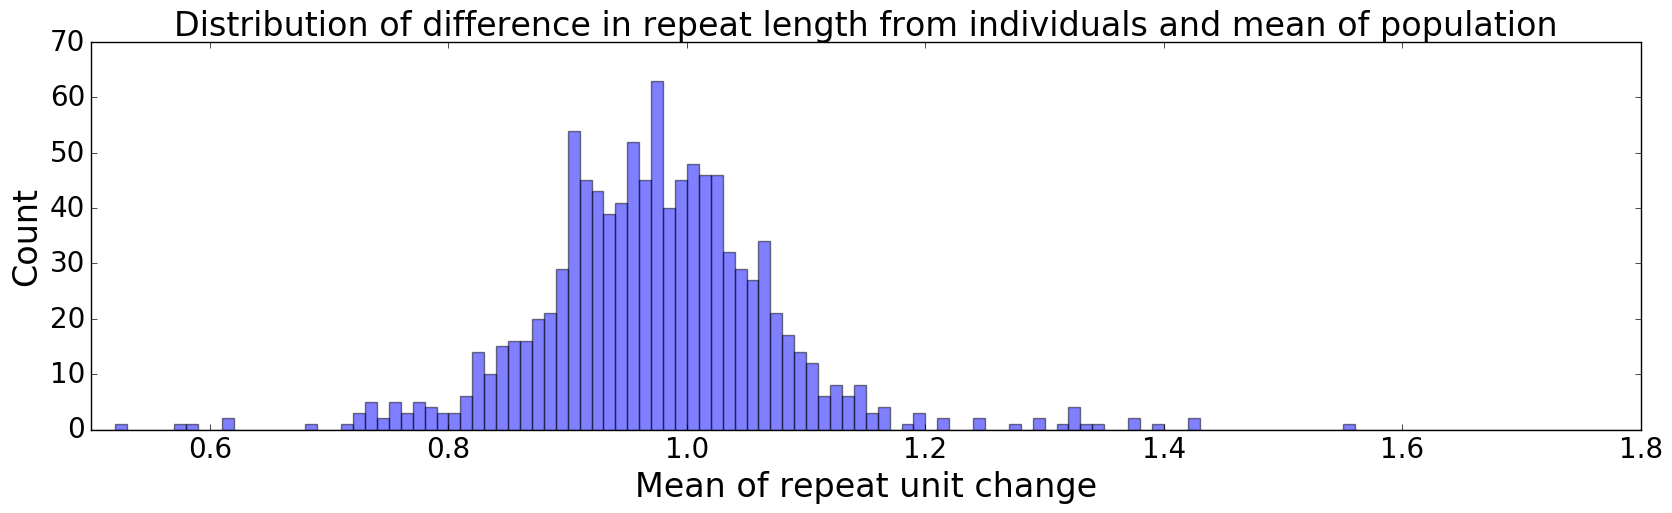

In [148]:
f, ax = plt.subplots()

rcParams['figure.figsize'] = 20, 5

ax.set_axis_bgcolor('white')

bins = np.arange(0, 2.5, 0.01) # fixed bin size

plt.xlim([min(frame.DIFF_FROM_POP_MEAN), max(frame.DIFF_FROM_POP_MEAN)])
plt.hist(frame.DIFF_FROM_POP_MEAN, bins=bins, alpha=0.5)

plt.title('Distribution of difference in repeat length from individuals and mean of population', fontsize=24)
plt.xlabel('Mean of repeat unit change', fontsize=24)
plt.ylabel('Count', fontsize=24)
plt.xlim(0.5, 1.8)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

What about the distribution of the biovariables?

In [243]:
biolst = []
for i in TriFullFrame.columns:
    if i.startswith('PREC') or i.startswith('MEAN') or i.startswith('MIN') or i.startswith('MAX') or i.startswith('TEMP'):
        biolst.append(i)

MEAN_DIURNAL_RANGE


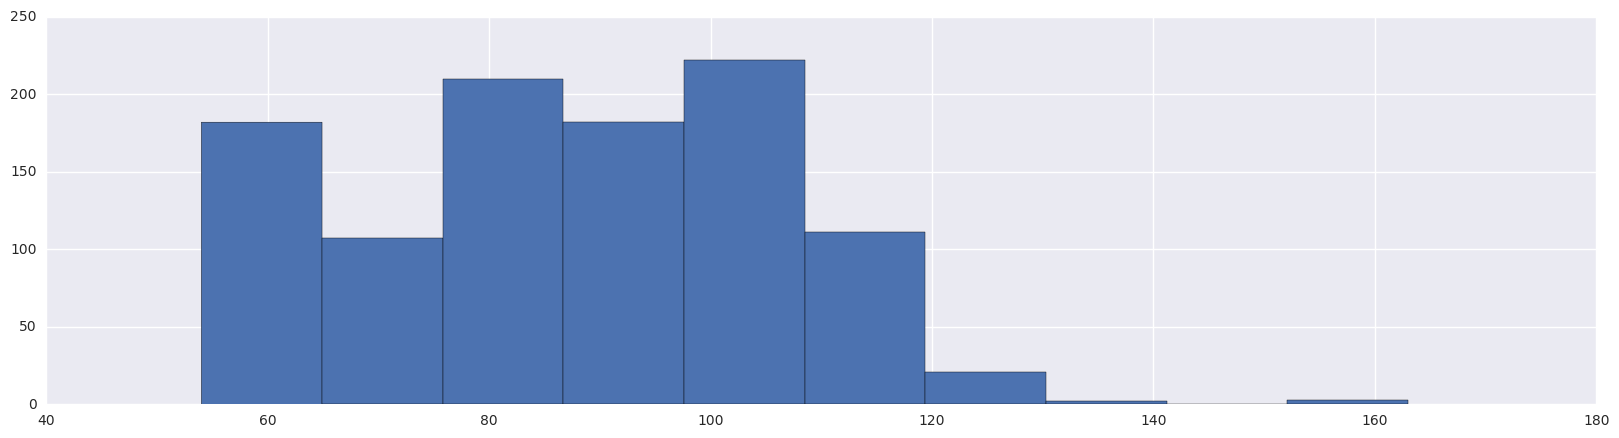

TEMP_SEASONALITY


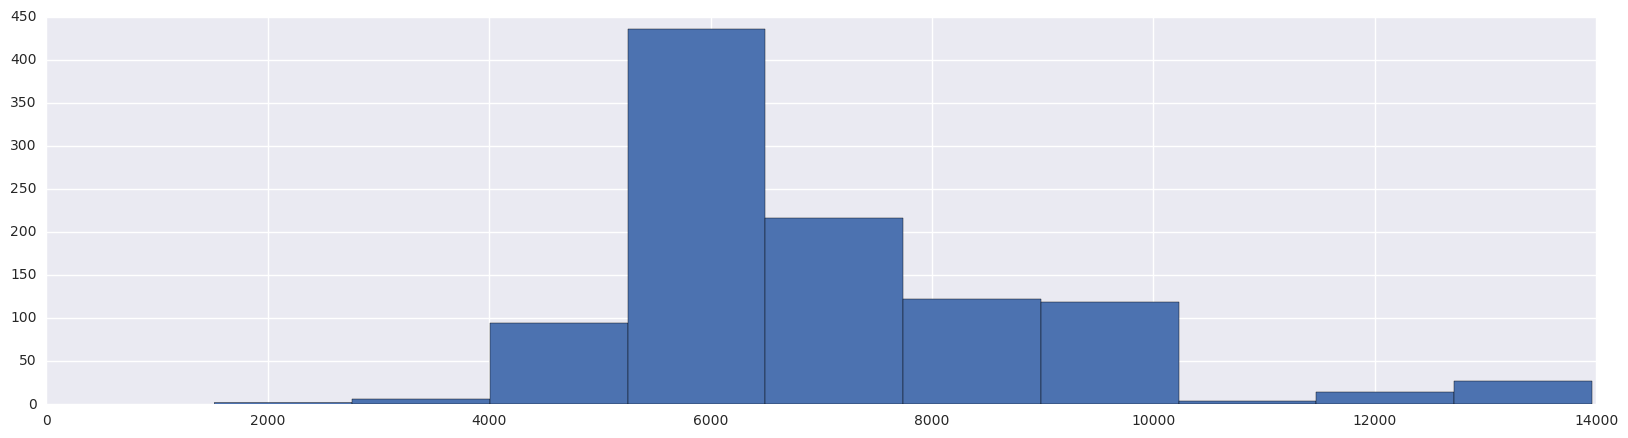

MAX_TEMP_WARMEST_MONTH


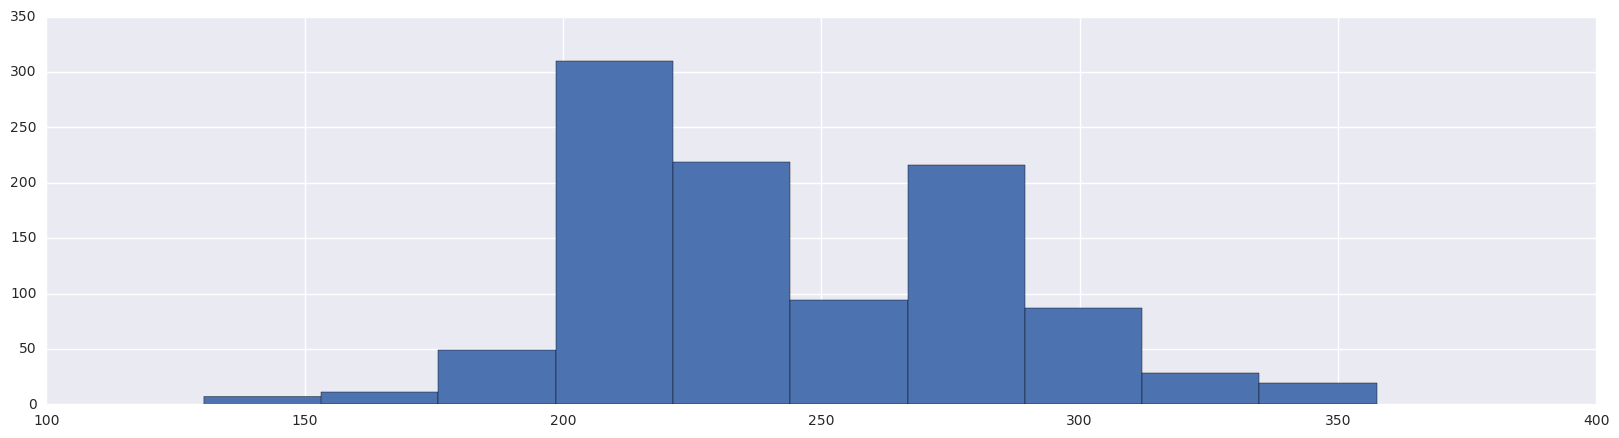

MIN_TEMP_COLDEST_MONTH


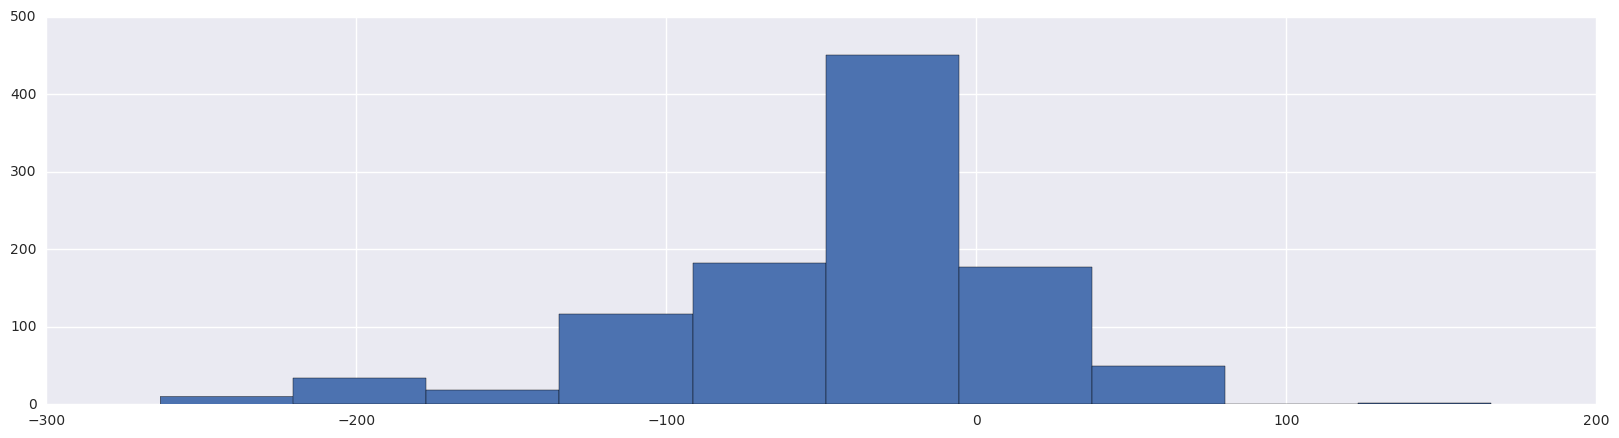

TEMP_ANNUAL_RANGE


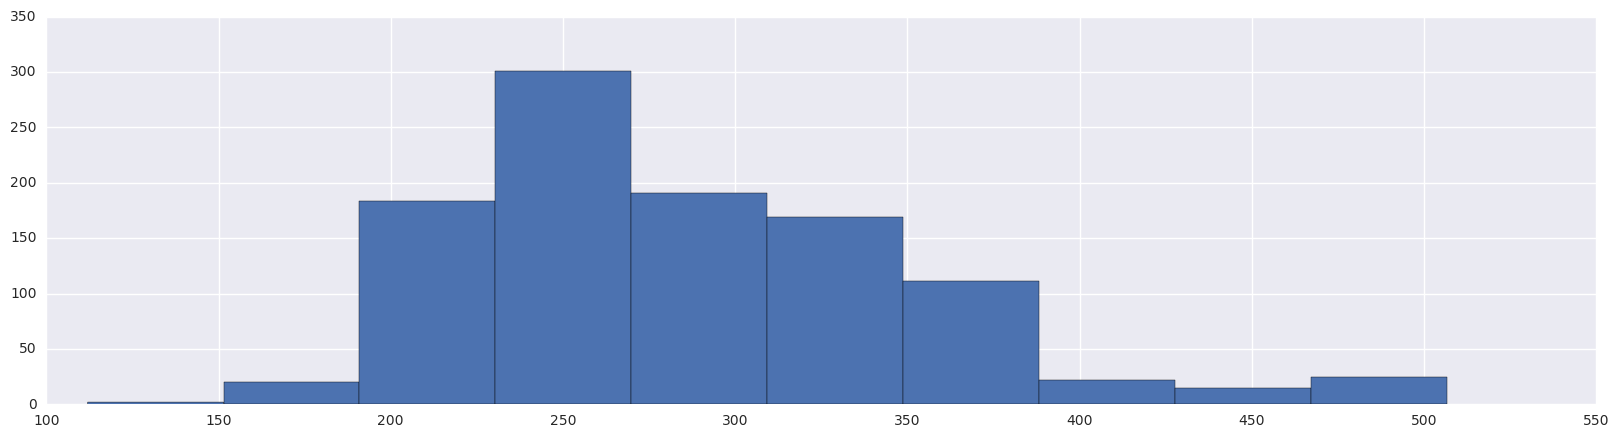

MEAN_TEMP_WETTEST_QUART


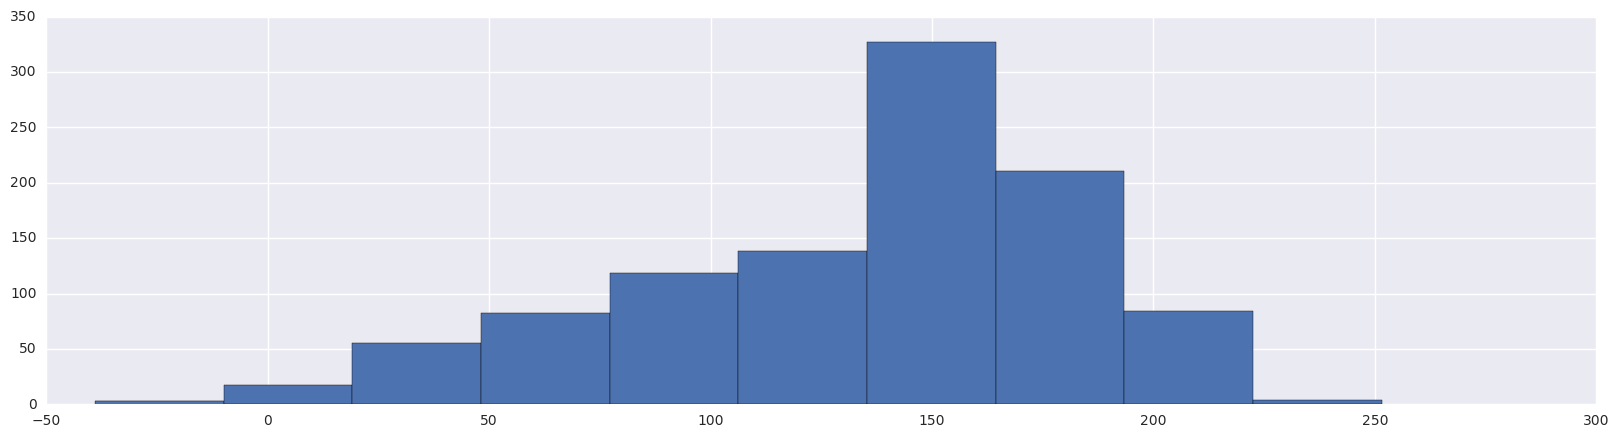

MEAN_TEMP_DRIEST_QUART


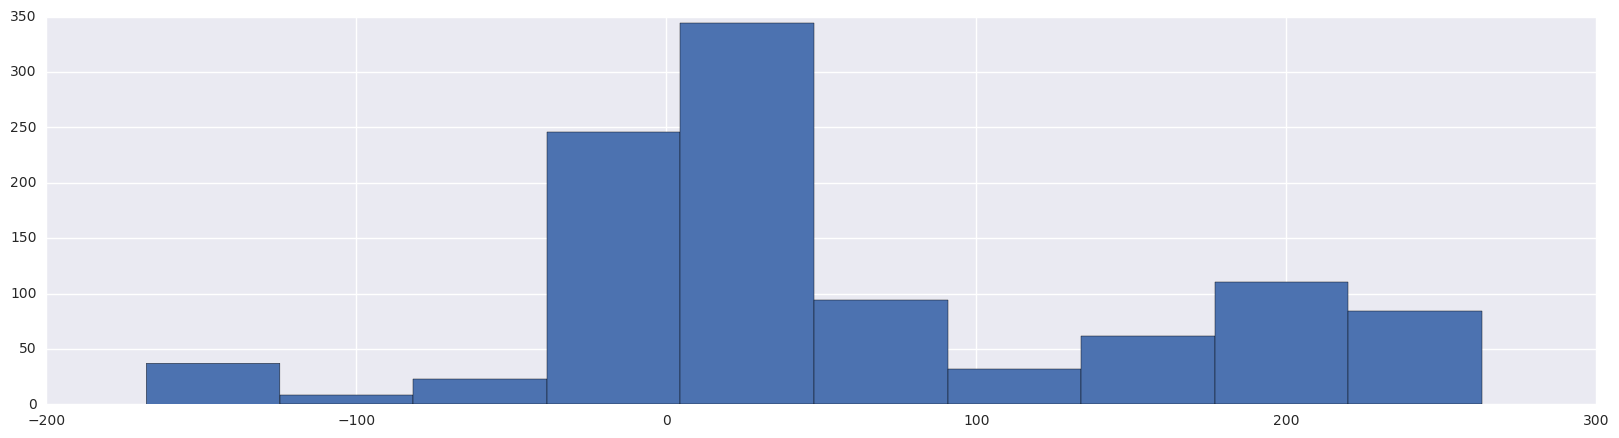

MEAN_TEMP_WARMEST_QUART


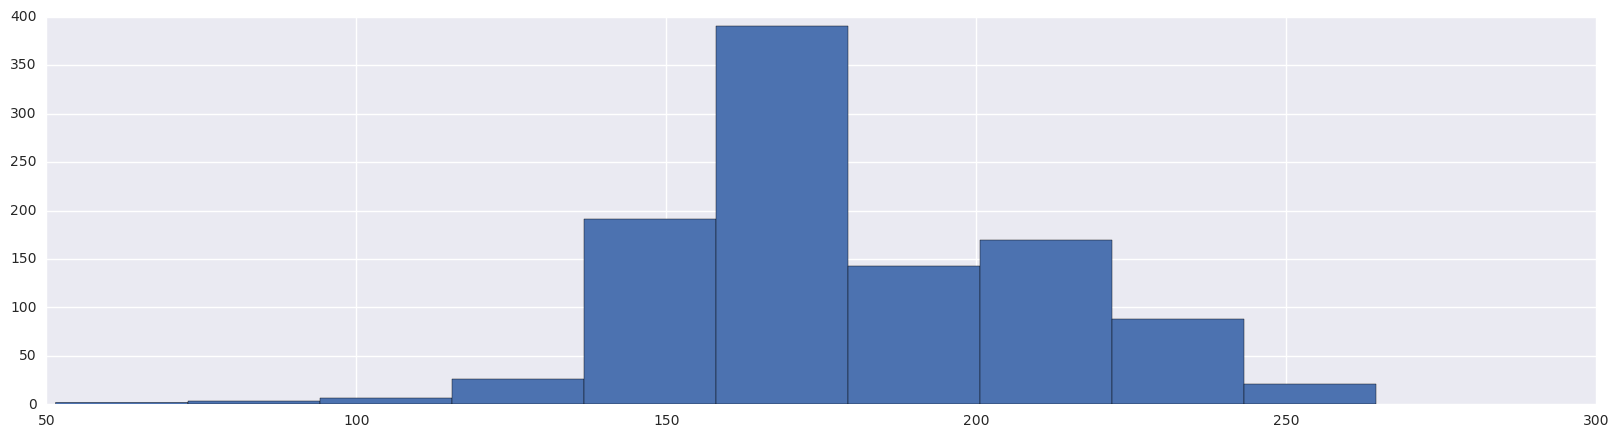

MEAN_TEMP_COLDEST_QUART


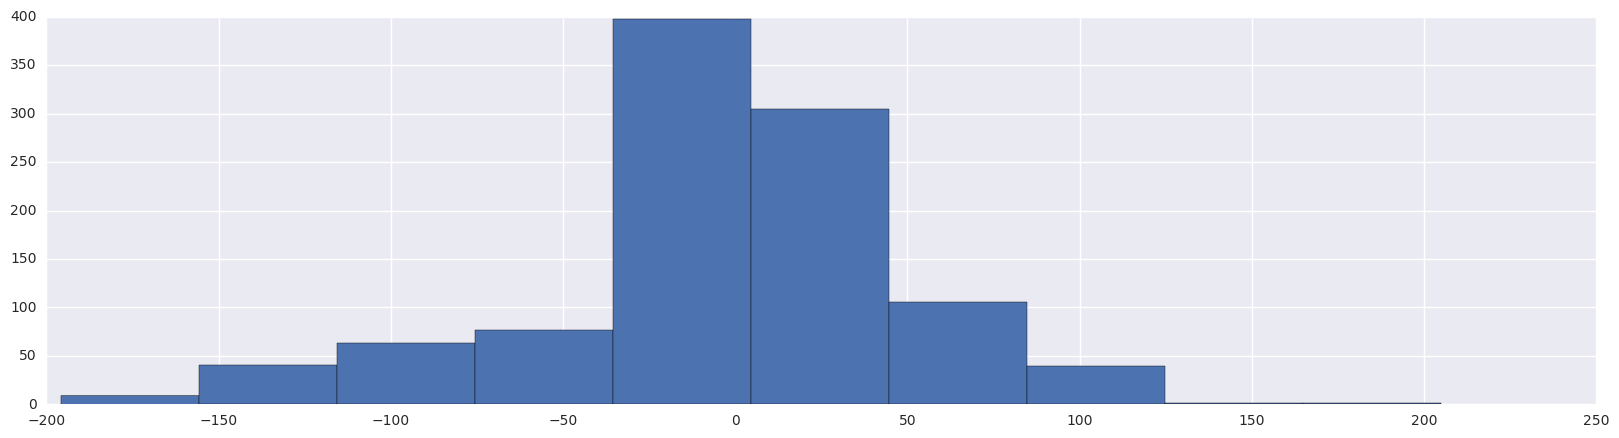

PREC_WETTEST_MONTH


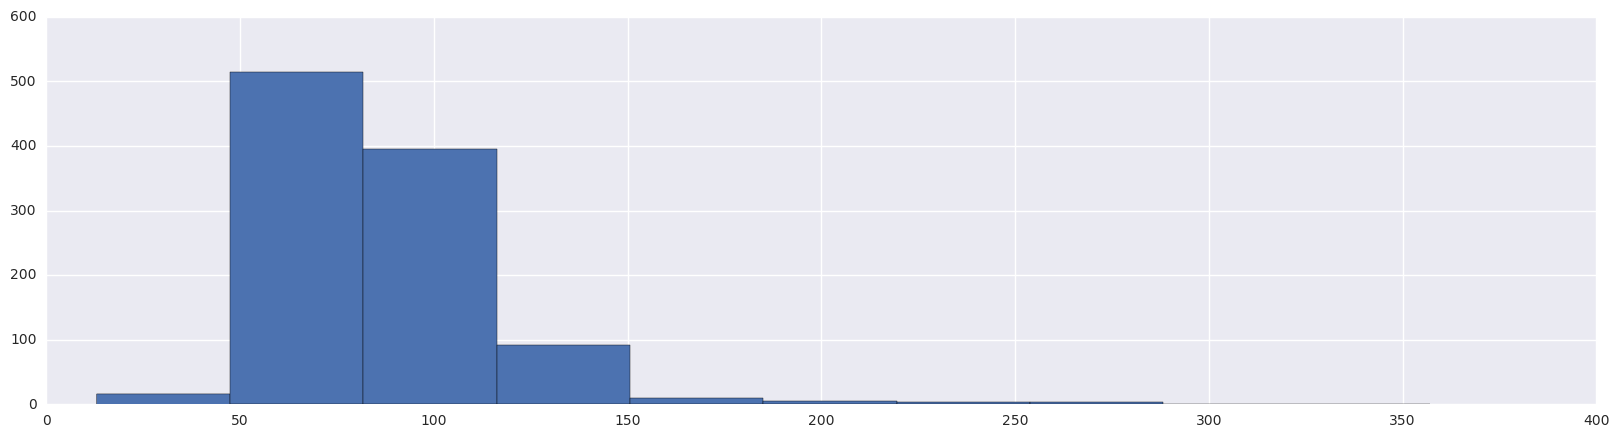

PREC_DRIEST_MONTH


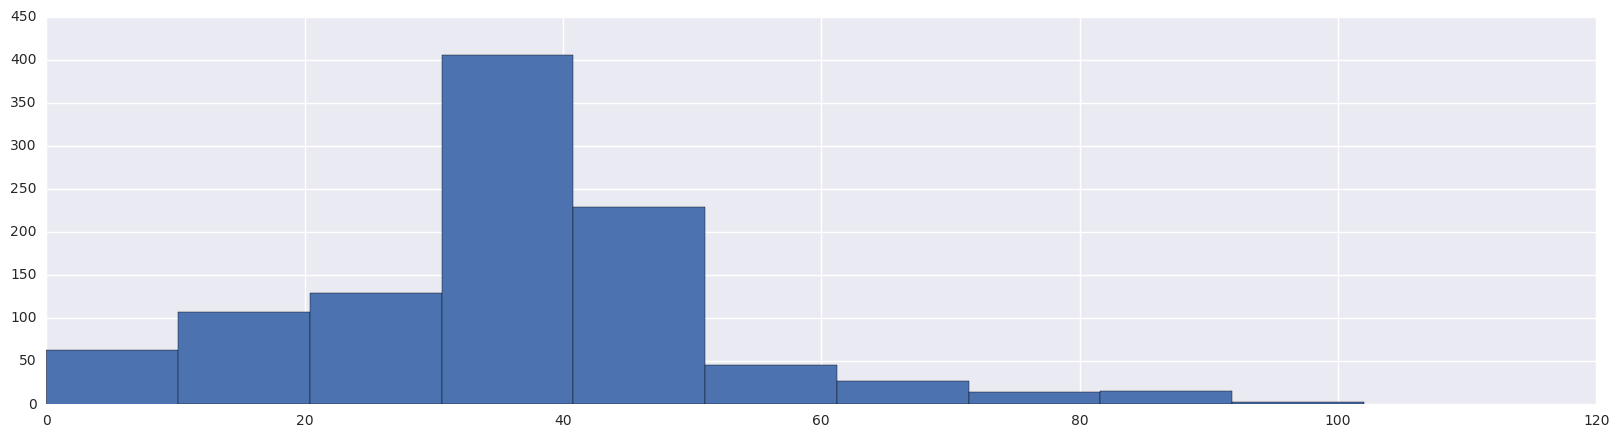

PREC_SEASONALITY


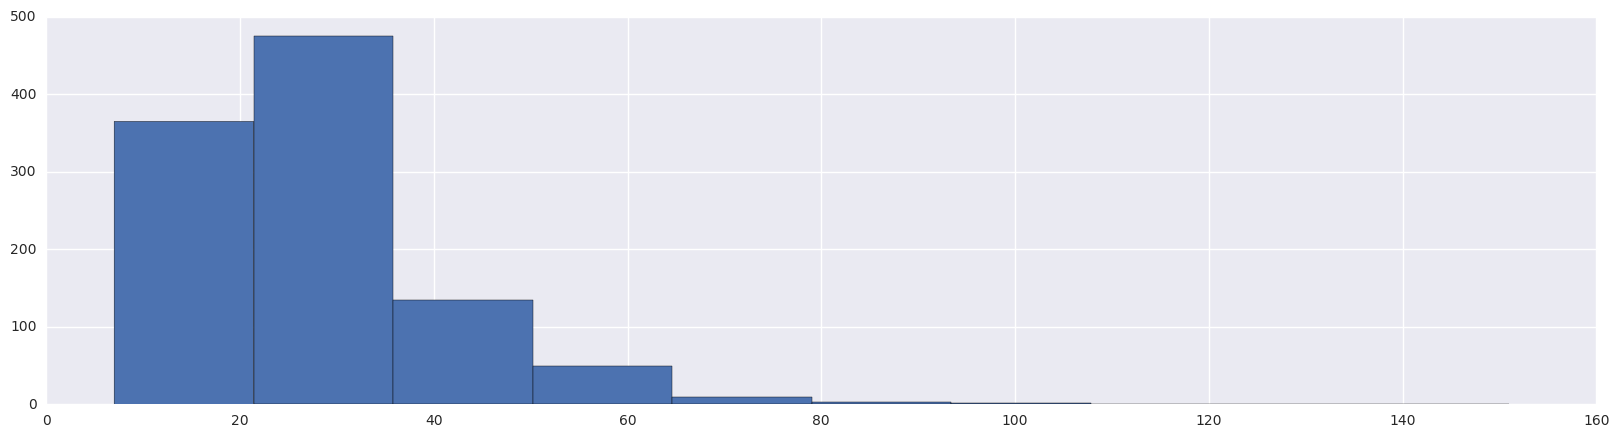

PREC_WETTEST_QUART


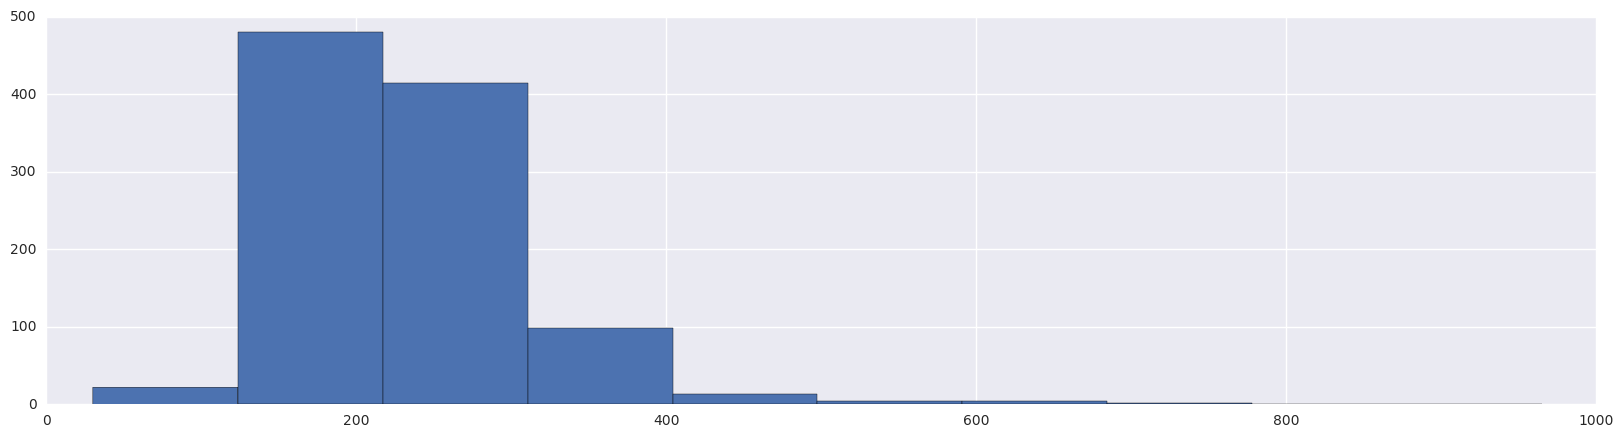

PREC_DRIEST_QUART


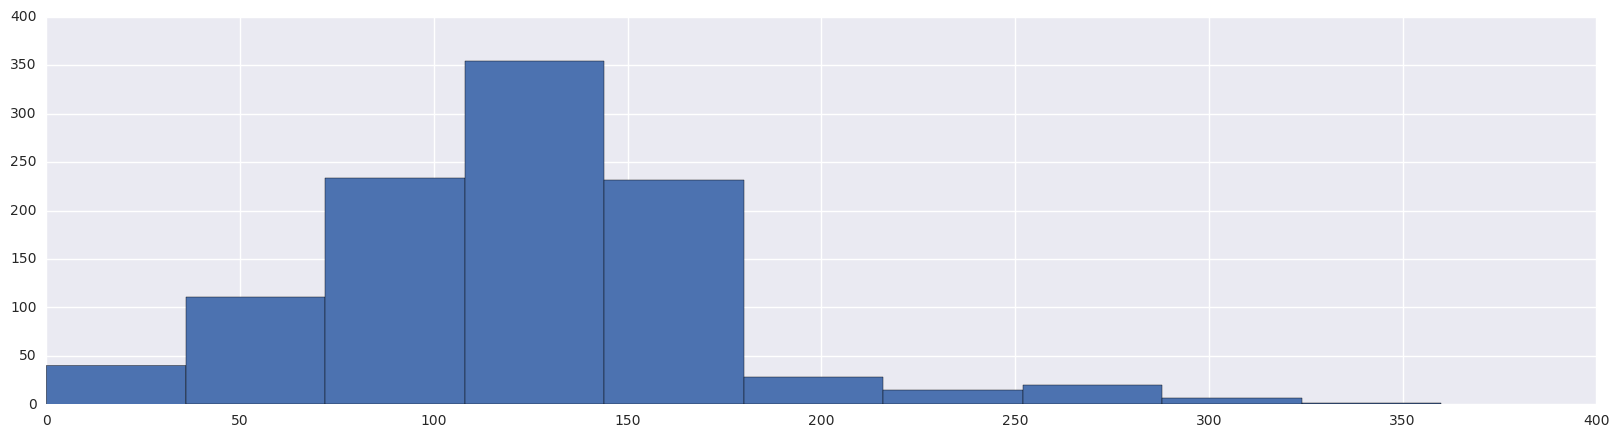

PREC_WARMEST_QUART


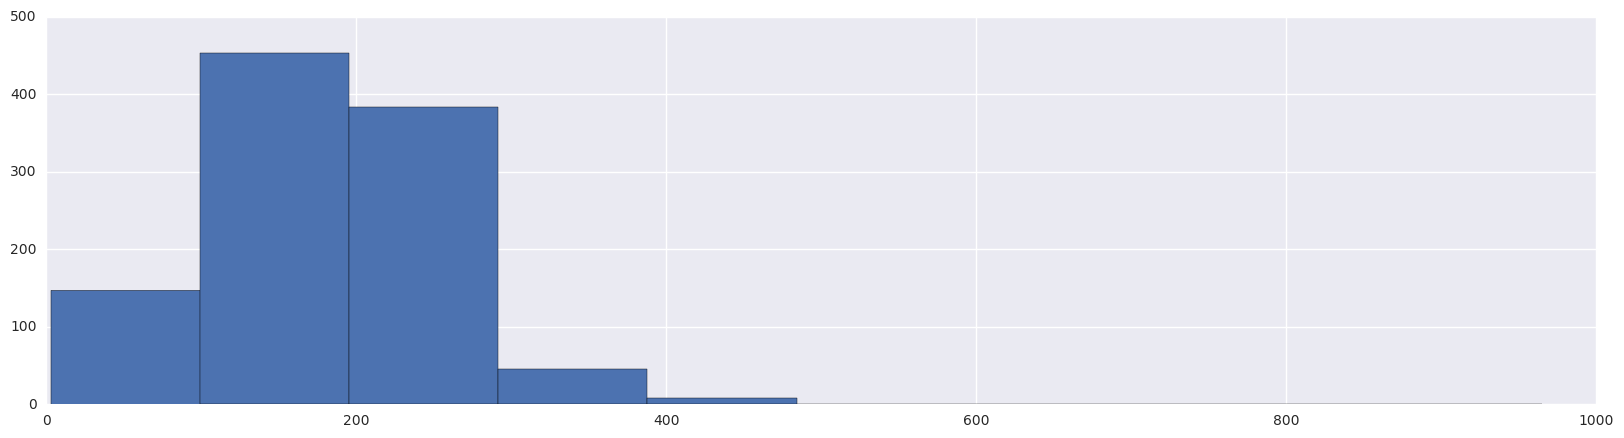

PREC_COLDEST_QUART


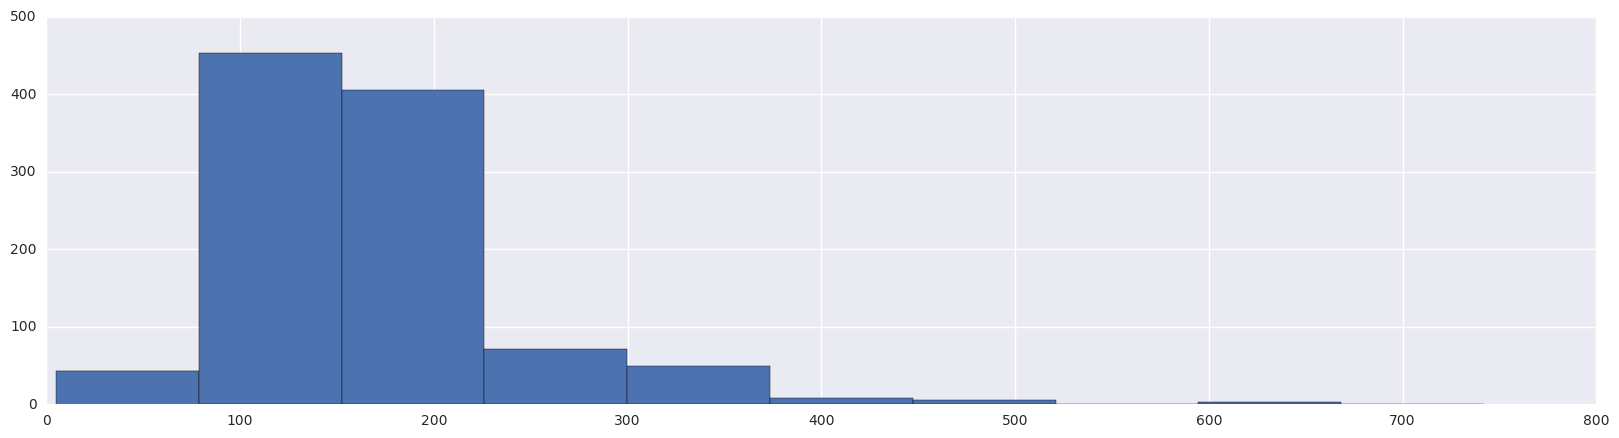

In [246]:
for biovariable in biolst:
    df[biovariable].hist()
    print biovariable
    plt.show()

### Removing outliers

In [187]:
frame.sort_values(by = 'DIFF_FROM_POP_MEAN', ascending=False).head(n=1)

,ACCESSION,DIFF_FROM_POP_MEAN
896,SRR1946533,2.941093


In [188]:
frame.sort_values(by = 'DIFF_FROM_POP_MEAN', ascending=True).head(n=1)

,ACCESSION,DIFF_FROM_POP_MEAN
921,SRR1945684,0.133659


SRR1946533 and SRR1945684 are outliers

In [194]:
frame = frame[~frame['ACCESSION'].isin(['SRR1945684', 'SRR1946533'])]

Plotting against clines

In [195]:
variables = []
for i in TriFullFrame.columns:
    if i == 'ACCESSION' or i == 'LATITUDE' or i == 'LONGITUDE' or i.startswith('PREC') or i.startswith('MEAN') or i.startswith('MIN') or i.startswith('MAX') or i.startswith('TEMP'):
        variables.append(i)
variables

a = AllGeneData[variables].groupby('ACCESSION').mean().reset_index()
final_frame = pd.merge(a, frame) 

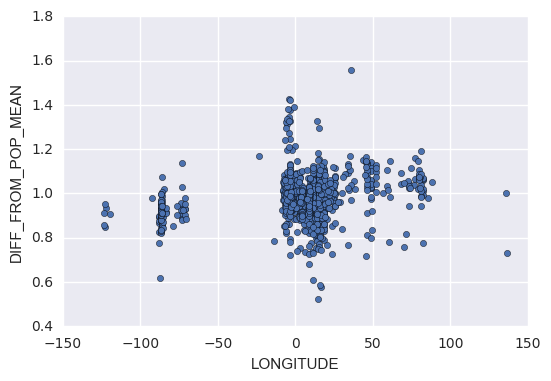

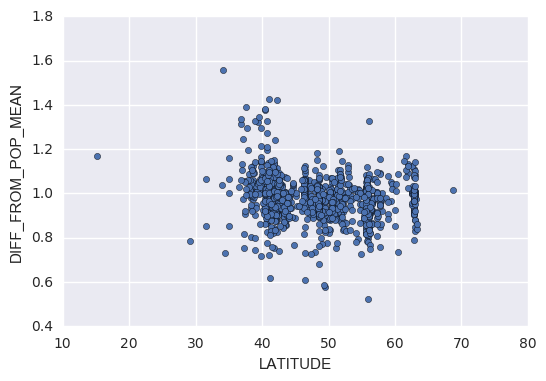

In [196]:
final_frame.plot(kind = 'scatter', x = 'LONGITUDE', y = 'DIFF_FROM_POP_MEAN')
final_frame.plot(kind = 'scatter', x = 'LATITUDE', y = 'DIFF_FROM_POP_MEAN')
plt.show()

In [197]:
max(d.PREC_SEASONALITY)

151.0

SpearmanrResult(correlation=-0.33372887320949707, pvalue=1.8960293901475513e-28)

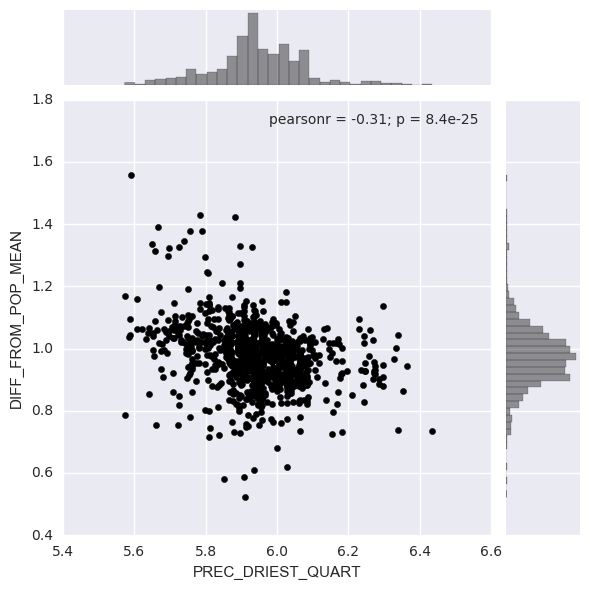

In [381]:
y = final_frame['DIFF_FROM_POP_MEAN']
a = sns.jointplot(y=y, x=np.log(final_frame['PREC_DRIEST_QUART'] + 263.251), color = color) 

STATS = stats.spearmanr(np.log(final_frame['PREC_DRIEST_QUART'] + 263.251),y)
STATS

In [256]:
min(np.log(d['MIN_TEMP_COLDEST_MONTH'] + 269.251))

1.7919261220073719

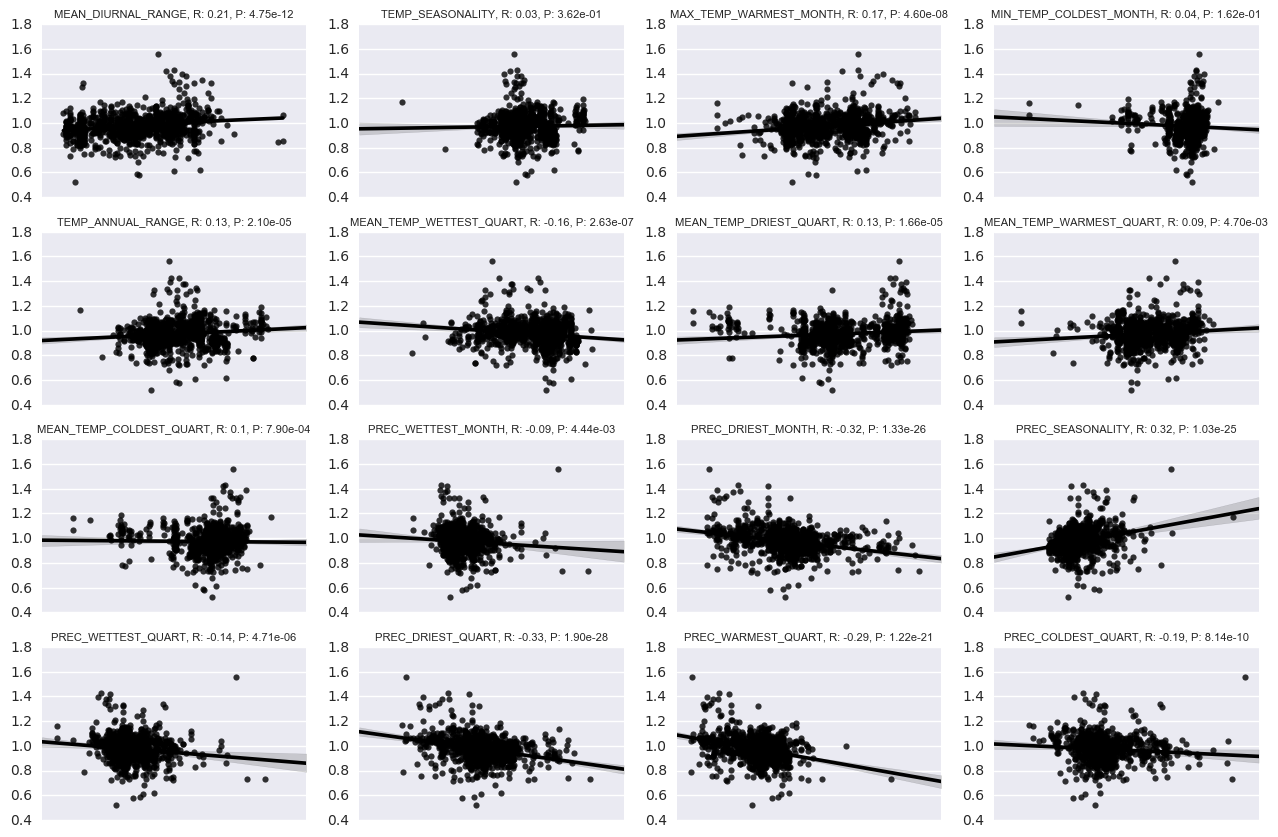

In [288]:
# Reducing multiple data points from same location (they have equal precipitation values)
d = final_frame#.drop_duplicates(subset = 'PREC_DRIEST_QUART', keep = 'first')

# Choose group here
group = 'admixture'

y = d['DIFF_FROM_POP_MEAN']

# Setting up a 4x4 plotting frame
fig, axes = plt.subplots(ncols=4, nrows = 4, figsize=(15.7, 10.27))

color = 'black'

constant = 269.251

a = sns.regplot(y=y, x=np.log(d['MEAN_DIURNAL_RANGE'] + constant), ax = axes[0,0], color = color, lowess = True, fit_reg = True) 
b = sns.regplot(y=y, x=np.log(d['TEMP_SEASONALITY'] + constant), ax = axes[0,1], color = color) 
c = sns.regplot(y=y, x=np.log(d['MAX_TEMP_WARMEST_MONTH'] + constant), ax = axes[0,2], color = color)
c2 = sns.regplot(y=y, x=np.log(d['MIN_TEMP_COLDEST_MONTH'] + constant), ax = axes[0,3], color = color)
e = sns.regplot(y=y, x=np.log(d['TEMP_ANNUAL_RANGE'] + constant), ax = axes[1,0], color = color)
f = sns.regplot(y=y, x=np.log(d['MEAN_TEMP_WETTEST_QUART'] + constant), ax = axes[1,1], color = color)
g = sns.regplot(y=y, x=np.log(d['MEAN_TEMP_DRIEST_QUART'] + constant), ax = axes[1,2], color = color)
h = sns.regplot(y=y, x=np.log(d['MEAN_TEMP_WARMEST_QUART'] + constant), ax = axes[1,3], color = color)
i = sns.regplot(y=y, x=np.log(d['MEAN_TEMP_COLDEST_QUART'] + constant), ax = axes[2,0], color = color)
j = sns.regplot(y=y, x=np.log(d['PREC_WETTEST_MONTH'] + constant), ax = axes[2,1], color = color)
k = sns.regplot(y=y, x=np.log(d['PREC_DRIEST_MONTH'] + constant), ax = axes[2,2], color = color)
l = sns.regplot(y=y, x=np.log(d['PREC_SEASONALITY'] + constant), ax = axes[2,3], color = color)
m = sns.regplot(y=y, x=np.log(d['PREC_WETTEST_QUART'] + constant), ax = axes[3,0], color = color)
n = sns.regplot(y=y, x=np.log(d['PREC_DRIEST_QUART'] + constant), ax = axes[3,1], color = color)
o = sns.regplot(y=y, x=np.log(d['PREC_WARMEST_QUART'] + constant), ax = axes[3,2], color = color)
p = sns.regplot(y=y, x=np.log(d['PREC_COLDEST_QUART'] + constant), ax = axes[3,3], color = color)

def biocorr(biovar, df):
    data = df.groupby('ACCESSION').mean()[['DIFF_FROM_POP_MEAN', biovar]]

    x = np.array(data[biovar]) + 263.251
    y = np.array(data['DIFF_FROM_POP_MEAN'])
    STATS = stats.spearmanr(x,y)
    return [STATS.correlation, STATS.pvalue]

    # Adjusting figure aesthetics for each plot
for figure in (a,b,c,c2,e,f,g,h,i,j,k,l,m,n,o,p):
    # Setting the xlabel as title, including correlation stats

    ylabel = str(figure.xaxis.get_label().get_text())

    SPEARMAN = biocorr(ylabel, d)
    R = round(SPEARMAN[0],2)
    P = format(SPEARMAN[1], '.2e')

    figure.set_title("%s, R: %s, P: %s" % (ylabel, R, P), fontdict = {'fontsize': 8})

    # Hiding xaxis, and yaxis label
    pylab.setp(figure.xaxis, visible=False)
    pylab.setp(figure.yaxis.label, visible=False)
plt.savefig('../Figures/BioClimAssociations_%s.pdf' % 'DIFF_FROM_POP_MEAN_BIOCLIM', type = 'pdf')

In [262]:
from __future__ import print_function
import numpy as np
import statsmodels.api as sm
from scipy import stats
from matplotlib import pyplot as plt

## General linearized model

No NaN allowed

In [305]:
d = d.dropna()

In [306]:
variables = []
for i in d.columns:
    if i == 'DIFF_FROM_POP_MEAN' or i.startswith('PREC') or i.startswith('MEAN') or i.startswith('MIN') or i.startswith('MAX') or i.startswith('TEMP'):
        variables.append(i)
variables

['MEAN_DIURNAL_RANGE',
 'TEMP_SEASONALITY',
 'MAX_TEMP_WARMEST_MONTH',
 'MIN_TEMP_COLDEST_MONTH',
 'TEMP_ANNUAL_RANGE',
 'MEAN_TEMP_WETTEST_QUART',
 'MEAN_TEMP_DRIEST_QUART',
 'MEAN_TEMP_WARMEST_QUART',
 'MEAN_TEMP_COLDEST_QUART',
 'PREC_WETTEST_MONTH',
 'PREC_DRIEST_MONTH',
 'PREC_SEASONALITY',
 'PREC_WETTEST_QUART',
 'PREC_DRIEST_QUART',
 'PREC_WARMEST_QUART',
 'PREC_COLDEST_QUART',
 'DIFF_FROM_POP_MEAN']

In [307]:
indep_variables = []
for i in d.columns:
    if i.startswith('PREC') or i.startswith('MEAN') or i.startswith('MIN') or i.startswith('MAX') or i.startswith('TEMP'):
        indep_variables.append(i)
indep_variables

['MEAN_DIURNAL_RANGE',
 'TEMP_SEASONALITY',
 'MAX_TEMP_WARMEST_MONTH',
 'MIN_TEMP_COLDEST_MONTH',
 'TEMP_ANNUAL_RANGE',
 'MEAN_TEMP_WETTEST_QUART',
 'MEAN_TEMP_DRIEST_QUART',
 'MEAN_TEMP_WARMEST_QUART',
 'MEAN_TEMP_COLDEST_QUART',
 'PREC_WETTEST_MONTH',
 'PREC_DRIEST_MONTH',
 'PREC_SEASONALITY',
 'PREC_WETTEST_QUART',
 'PREC_DRIEST_QUART',
 'PREC_WARMEST_QUART',
 'PREC_COLDEST_QUART']

In [308]:
data = d[variables]

In [309]:
dep_variable = np.array(data['DIFF_FROM_POP_MEAN'])

In [331]:
len(dep_variable)

1038

In [315]:
indep = np.array(data[indep_variables])

In [333]:
len(indep)

1038

In [317]:
glm_binom = sm.GLM(dep_variable, indep, family=sm.families.Gaussian())
res = glm_binom.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 1038
Model:                            GLM   Df Residuals:                     1023
Model Family:                Gaussian   Df Model:                           14
Link Function:               identity   Scale:                 0.0141861228234
Method:                          IRLS   Log-Likelihood:                 743.30
Date:                Fri, 11 Nov 2016   Deviance:                       14.512
Time:                        14:25:09   Pearson chi2:                     14.5
No. Iterations:                     4                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1            -0.0067      0.001     -6.655      0.000        -0.009    -0.005
x2             0.0006   6.66e-05      8.520      0.0

In [347]:
res.pvalues

array([  2.82657611e-11,   1.60077384e-17,   8.40268975e-20,
         3.50081070e-01,   4.05008598e-15,   2.76999496e-03,
         9.15319617e-01,   4.12310663e-29,   3.45285894e-17,
         3.68892004e-01,   3.07470428e-16,   1.02695009e-34,
         3.06667282e-02,   5.62274483e-02,   9.41422919e-02,
         2.56775089e-04])

In [348]:
d.columns[3:-1]

Index([u'MEAN_DIURNAL_RANGE', u'TEMP_SEASONALITY', u'MAX_TEMP_WARMEST_MONTH',
       u'MIN_TEMP_COLDEST_MONTH', u'TEMP_ANNUAL_RANGE',
       u'MEAN_TEMP_WETTEST_QUART', u'MEAN_TEMP_DRIEST_QUART',
       u'MEAN_TEMP_WARMEST_QUART', u'MEAN_TEMP_COLDEST_QUART',
       u'PREC_WETTEST_MONTH', u'PREC_DRIEST_MONTH', u'PREC_SEASONALITY',
       u'PREC_WETTEST_QUART', u'PREC_DRIEST_QUART', u'PREC_WARMEST_QUART',
       u'PREC_COLDEST_QUART'],
      dtype='object')

In [353]:
dep_variable.sum()

1010.1902200393004

In [354]:
nobs = res.nobs
y = dep_variable/dep_variable.sum()
yhat = res.mu

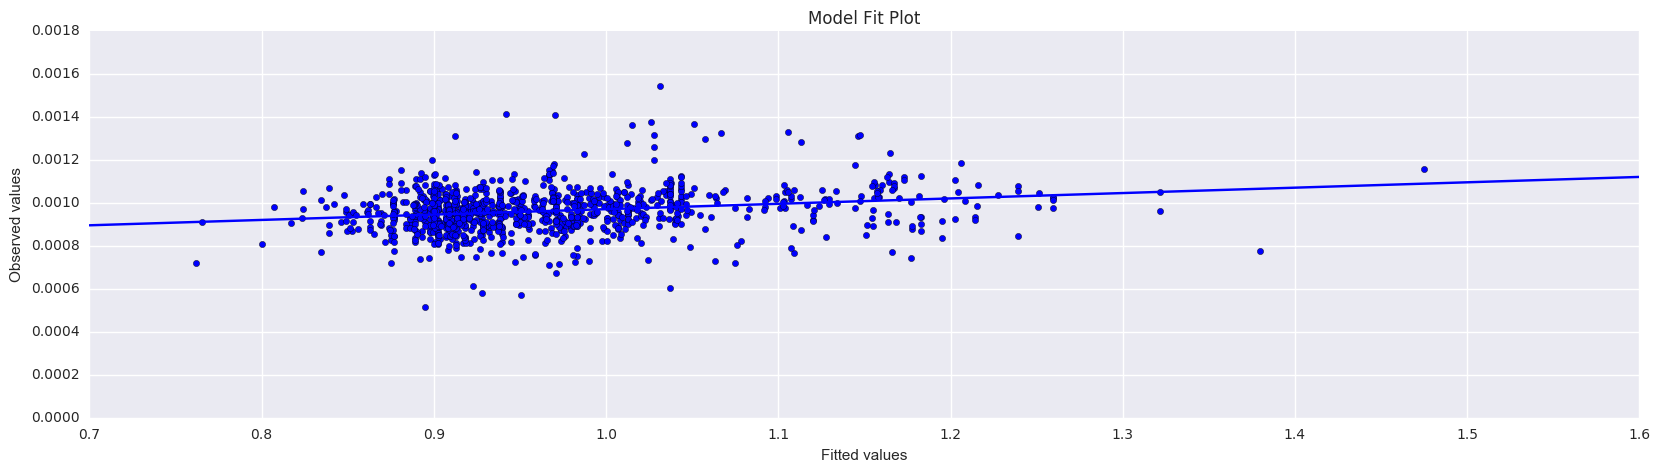

In [364]:
fig, ax = plt.subplots()
ax.scatter(yhat, y)
line_fit = sm.OLS(y, sm.add_constant(yhat, prepend=True)).fit()
abline_plot(model_results=line_fit, ax=ax)

ax.set_ylim(ymin = 0, ymax = 0.0018)
ax.set_title('Model Fit Plot')
ax.set_ylabel('Observed values')
ax.set_xlabel('Fitted values');

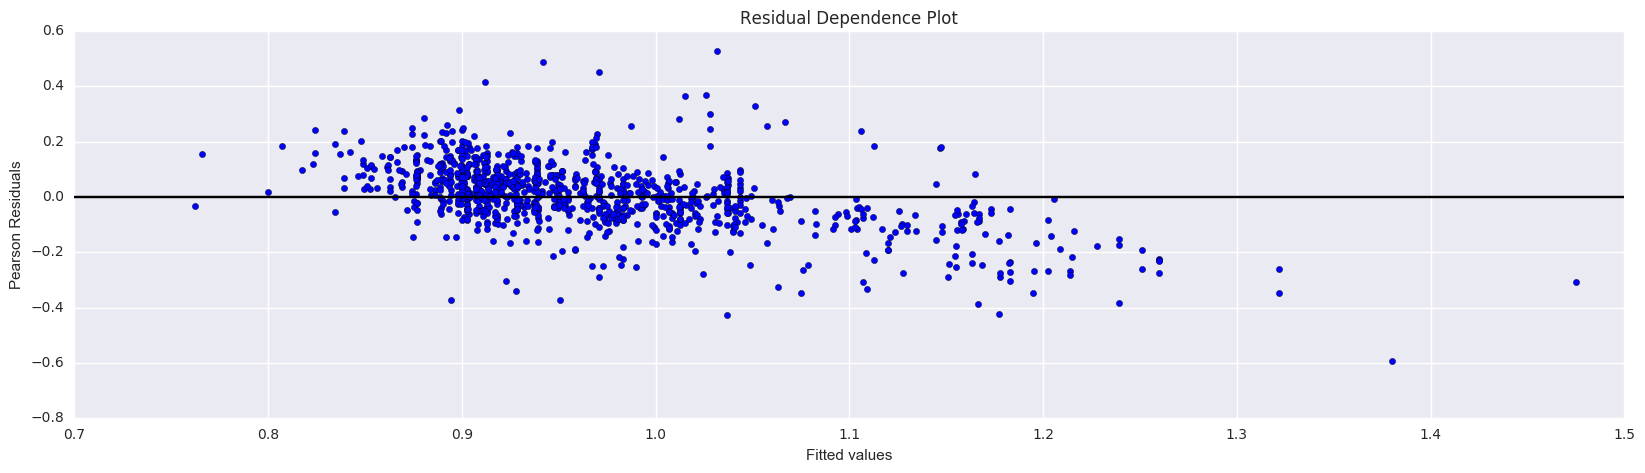

In [374]:
fig, ax = plt.subplots()

ax.scatter(yhat, res.resid_pearson)
ax.hlines(0, 0, 1.5)
ax.set_xlim(0.7,1.5)
ax.set_title('Residual Dependence Plot')
ax.set_ylabel('Pearson Residuals')
ax.set_xlabel('Fitted values')

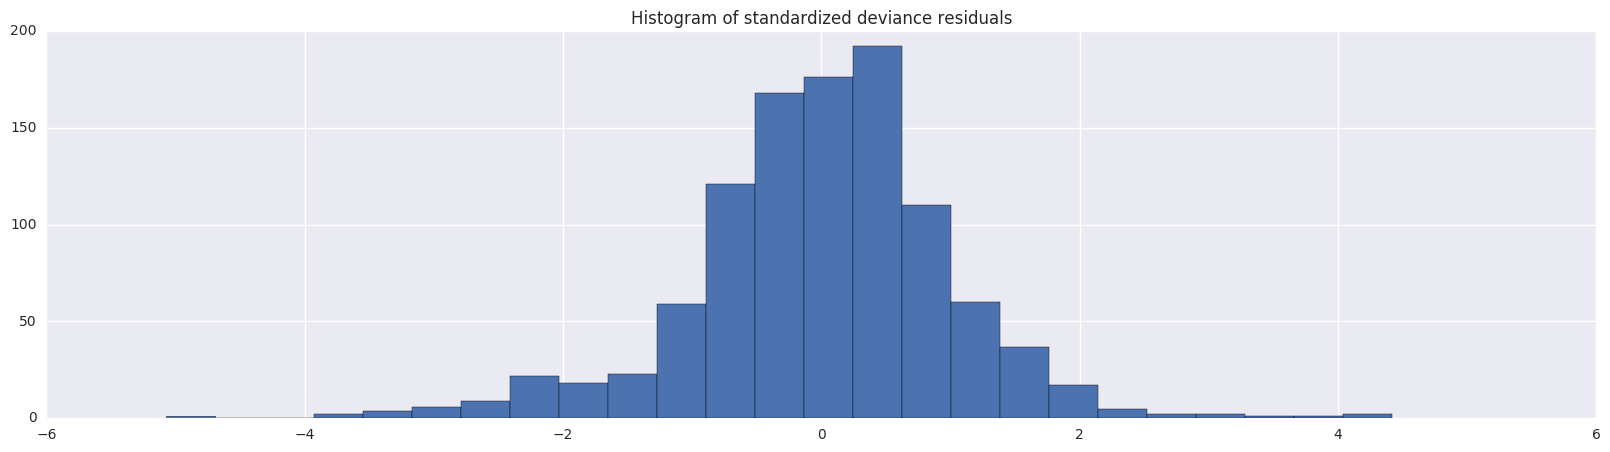

In [375]:
from scipy import stats

fig, ax = plt.subplots()

resid = res.resid_deviance.copy()
resid_std = stats.zscore(resid)
ax.hist(resid_std, bins=25)
ax.set_title('Histogram of standardized deviance residuals');

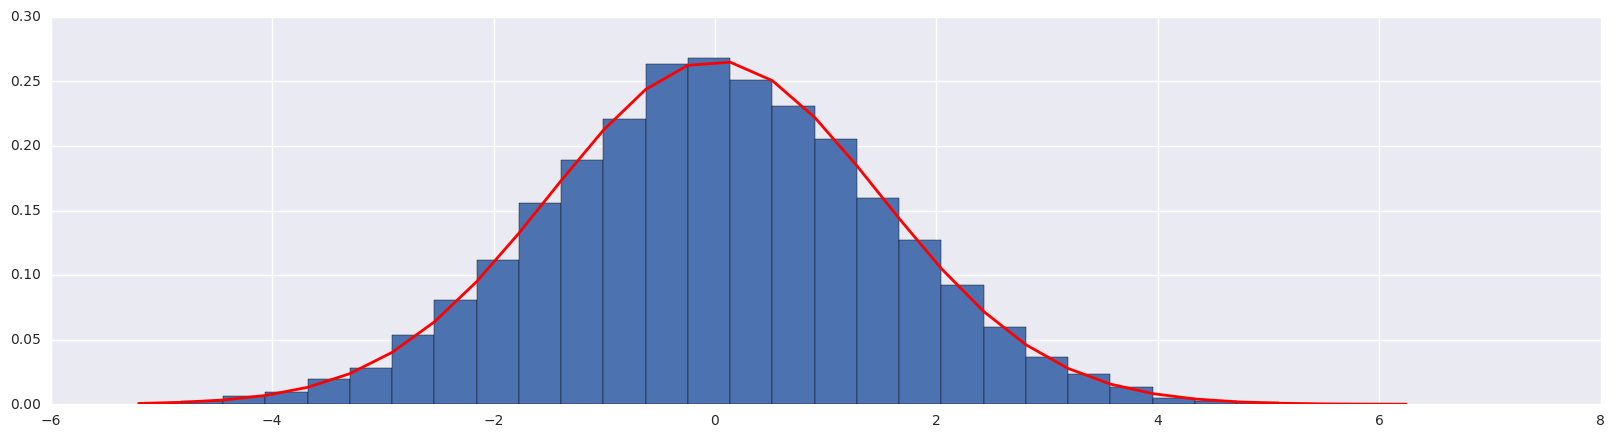

In [408]:
mu, sigma = 0, 1.5
s = np.random.normal(mu, sigma, 10000)

count, bins, ignored = plt.hist(s, 30, normed=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
         np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.show()

In [ ]:
norm_x = np.random

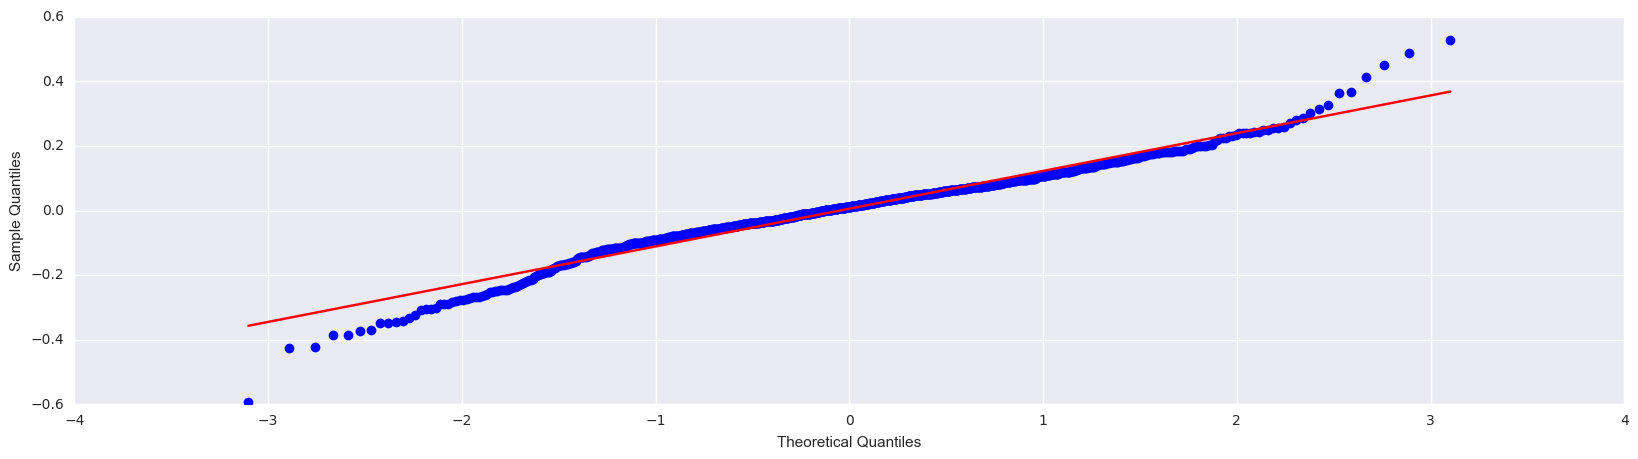

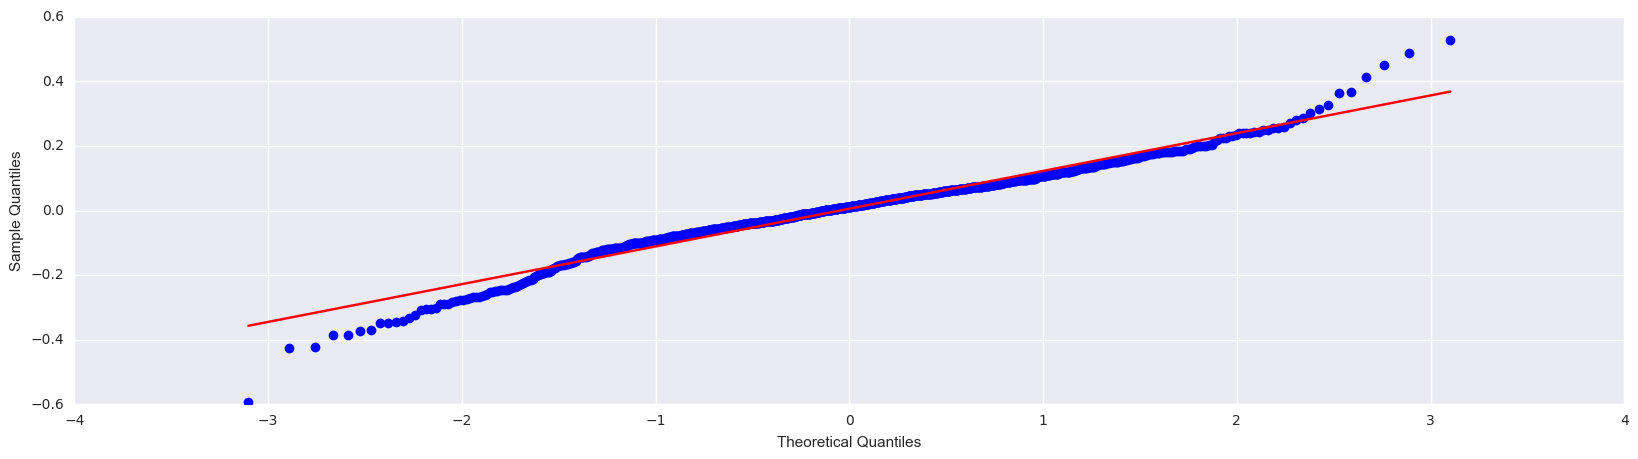

In [378]:
from statsmodels import graphics
graphics.gofplots.qqplot(resid, line='r')

In [323]:
means = indep.mean(axis=0)
means25 = means.copy()
means25[0] = stats.scoreatpercentile(indep, 25)
means75 = means.copy()
means75[0] = lowinc_75per = stats.scoreatpercentile(indep, 75)
resp_25 = res.predict(means25)
resp_75 = res.predict(means75)
diff = resp_75 - resp_25

In [329]:
nobs = res.nobs
y = dep_variable[:,0]/dep_variable.sum(1)
yhat = res.mu

IndexError: too many indices for array

In [325]:
nobs = res.nobs
y = data.endog[:,0]/data.endog.sum(1)
yhat = res.mu